In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, auc, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the train, validation, and test splits
train_data = pd.read_csv('datasets_processed/train.csv')
val_data = pd.read_csv('datasets_processed/validation.csv')
test_data = pd.read_csv('datasets_processed/test.csv')

# Drop any rows with missing values
train_data.dropna(inplace=True)
val_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Split dataset into train, validation, and test sets
X_train = train_data['message']
y_train = train_data['label']

X_val = val_data['message']
y_val = val_data['label']

X_test = test_data['message']
y_test = test_data['label']

# Convert text data to numerical format using TF-IDF with sublinear TF scaling
tfidf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2), max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_val_tfidf = tfidf.transform(X_val).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

In [3]:
# Function to fit a model
def fit_model(model, X_train, y_train):
    """Fit a model on training data."""
    model.fit(X_train, y_train)
    return model

# Function to score a model
def score_model(model, X, y):
    """Score a model on given data."""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None
    return y_pred, y_proba

# Function to evaluate a model
def evaluate_model(y_true, y_pred, y_proba=None):
    """Evaluate model predictions."""
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    if y_proba is not None:
        print("ROC-AUC Score:", roc_auc_score(y_true, y_proba))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# Function to validate a model
def validate_model(model, X_train, y_train, X_val, y_val):
    """Validate a model on train and validation data."""
    print("Training Data Evaluation:")
    y_train_pred, y_train_proba = score_model(model, X_train, y_train)
    evaluate_model(y_train, y_train_pred, y_train_proba)

    print("\nValidation Data Evaluation:")
    y_val_pred, y_val_proba = score_model(model, X_val, y_val)
    evaluate_model(y_val, y_val_pred, y_val_proba)

# Function to fine-tune hyperparameters
def fine_tune_model(model, param_grid, X_train, y_train, X_val, y_val, cv=3):
    """Fine-tune hyperparameters using GridSearchCV."""
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best ROC-AUC Score:", grid_search.best_score_)

    # Validate the best model
    best_model = grid_search.best_estimator_
    validate_model(best_model, X_train, y_train, X_val, y_val)
    return best_model

# Function to benchmark models
def benchmark_models(models, X_test, y_test):
    """Score and compare multiple models on test data."""
    for name, model in models.items():
        print(f"\n{name} Model Evaluation:")
        y_test_pred, y_test_proba = score_model(model, X_test, y_test)
        evaluate_model(y_test, y_test_pred, y_test_proba)

def plot_confusion_matrix_and_roc_auc(y_true, y_pred, y_pred_proba, model_name):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot confusion matrix heatmap
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'Confusion Matrix for {model_name}')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # Plot ROC-AUC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'ROC Curve for {model_name}')
    ax2.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

Reports for Validation set

Fitting and Validating Logistic Regression...
Validation Metrics for Logistic Regression:


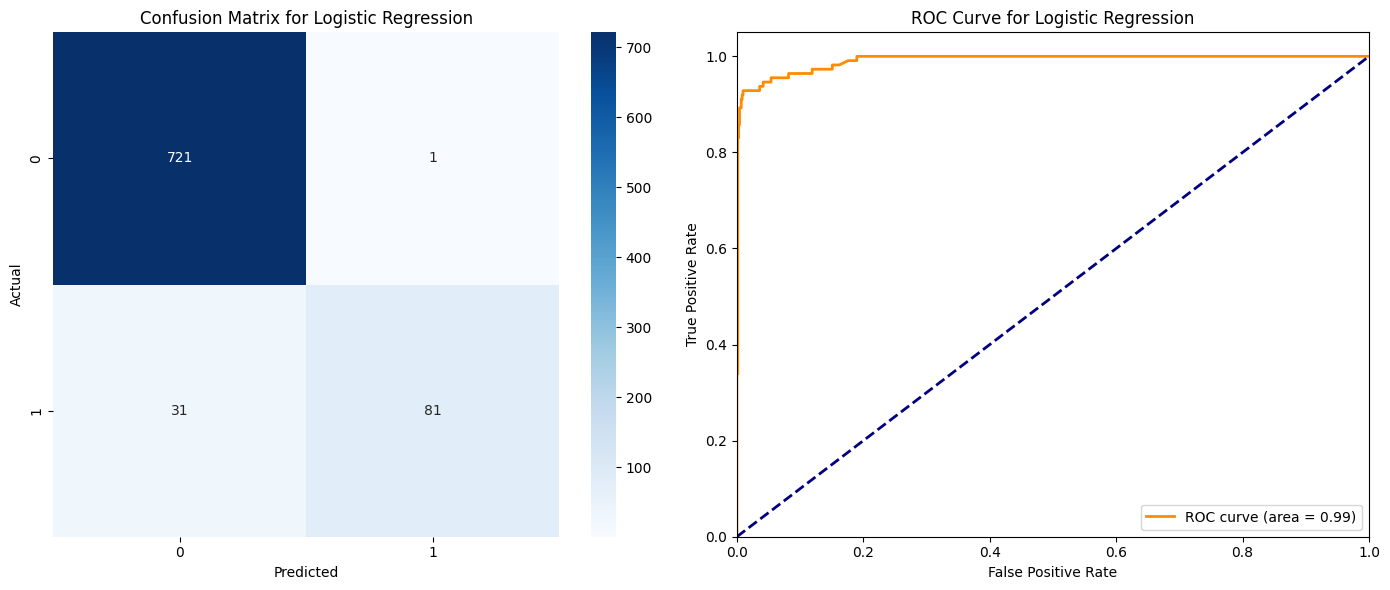

__________________________________________________

Fitting and Validating Multinomial Naive Bayes...
Validation Metrics for Multinomial Naive Bayes:


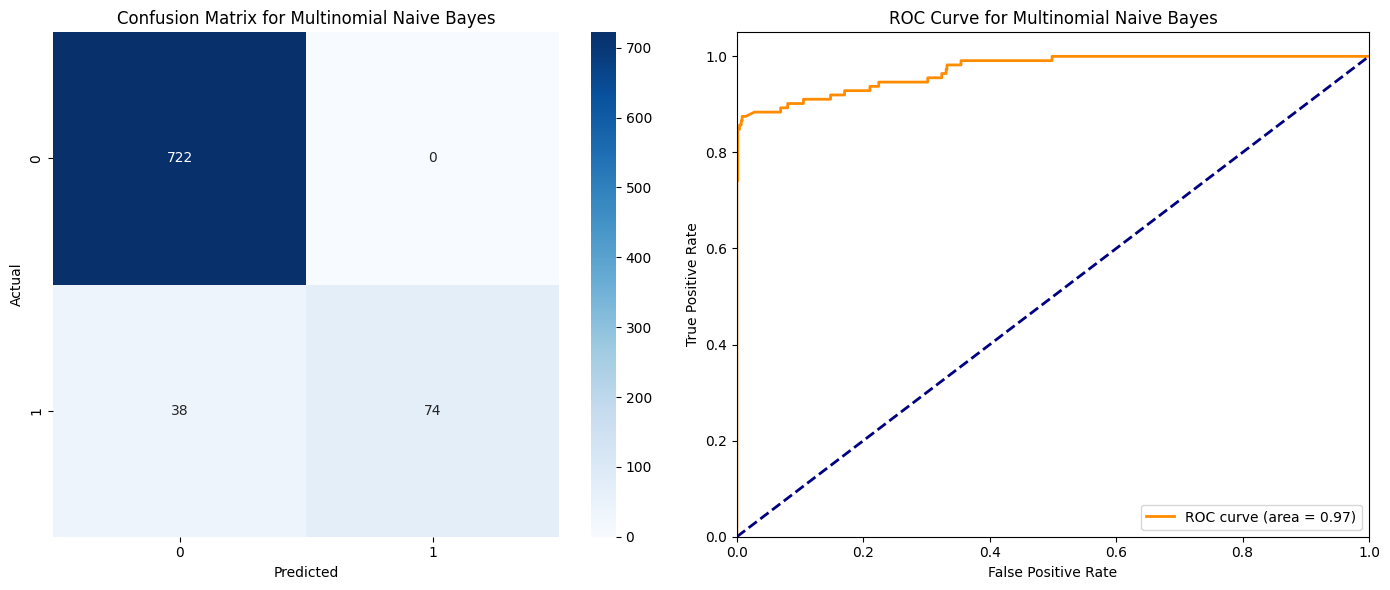

__________________________________________________

Fitting and Validating Random Forest...
Validation Metrics for Random Forest:


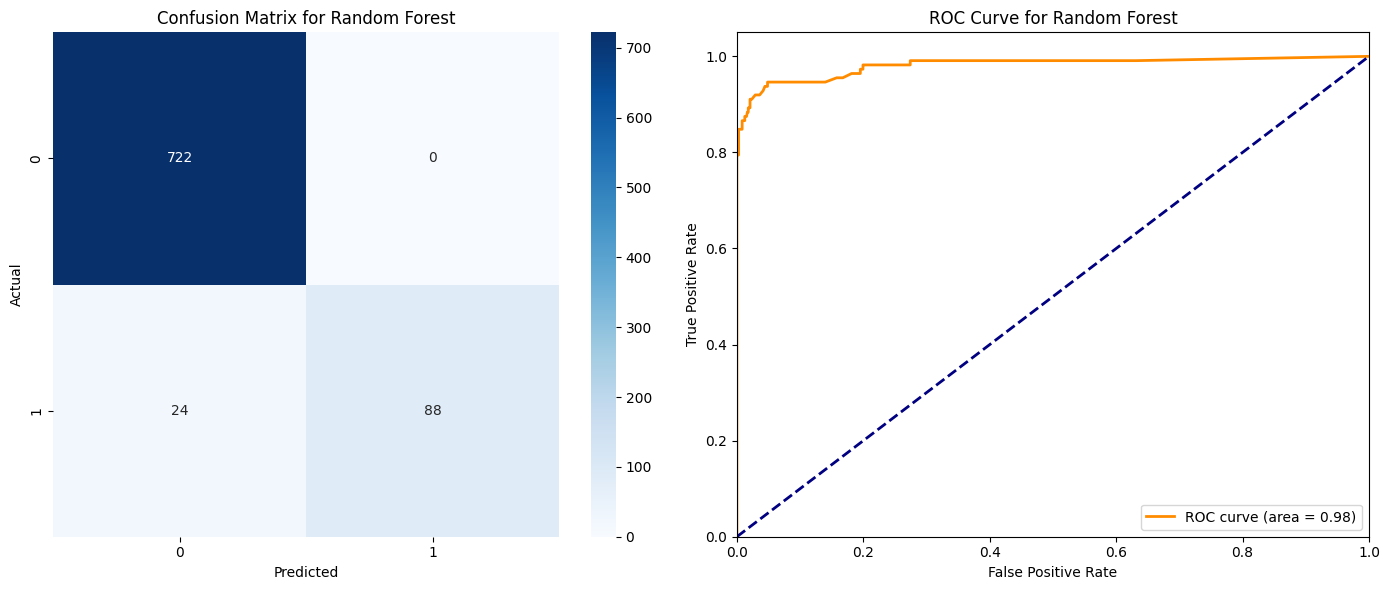

__________________________________________________

Fitting and Validating XGBoost...
Validation Metrics for XGBoost:


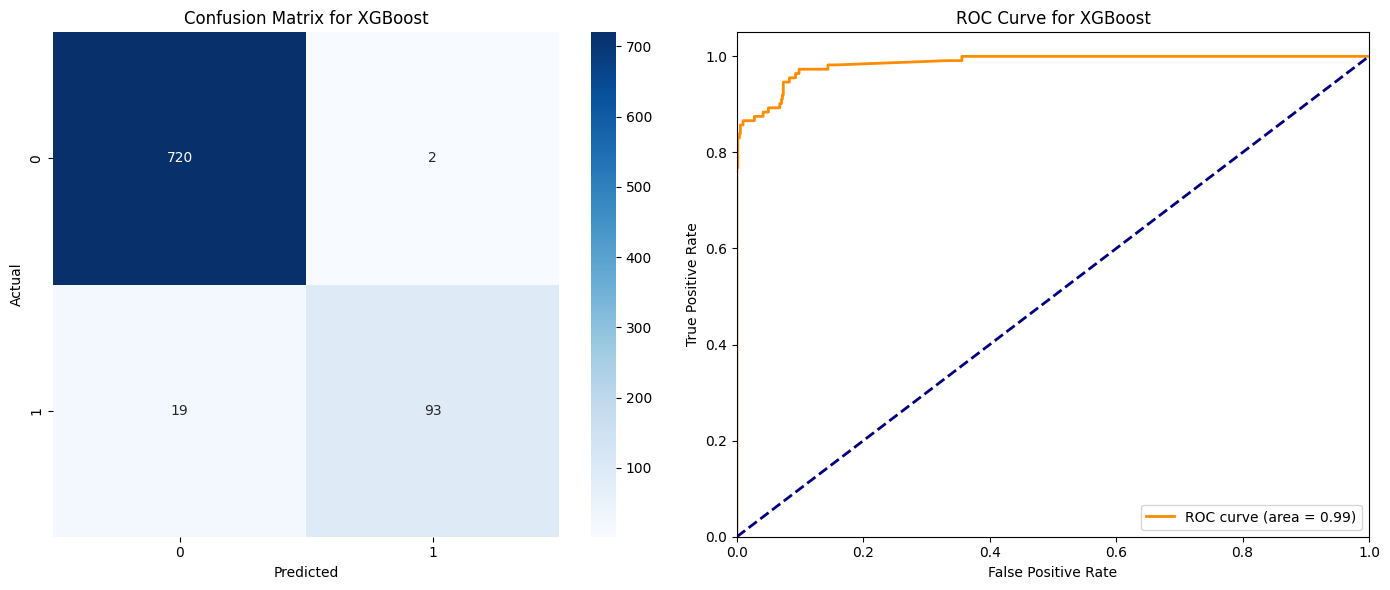

__________________________________________________
Reports for Test set

Benchmarking Models on Test Data...
Test Metrics for Logistic Regression:


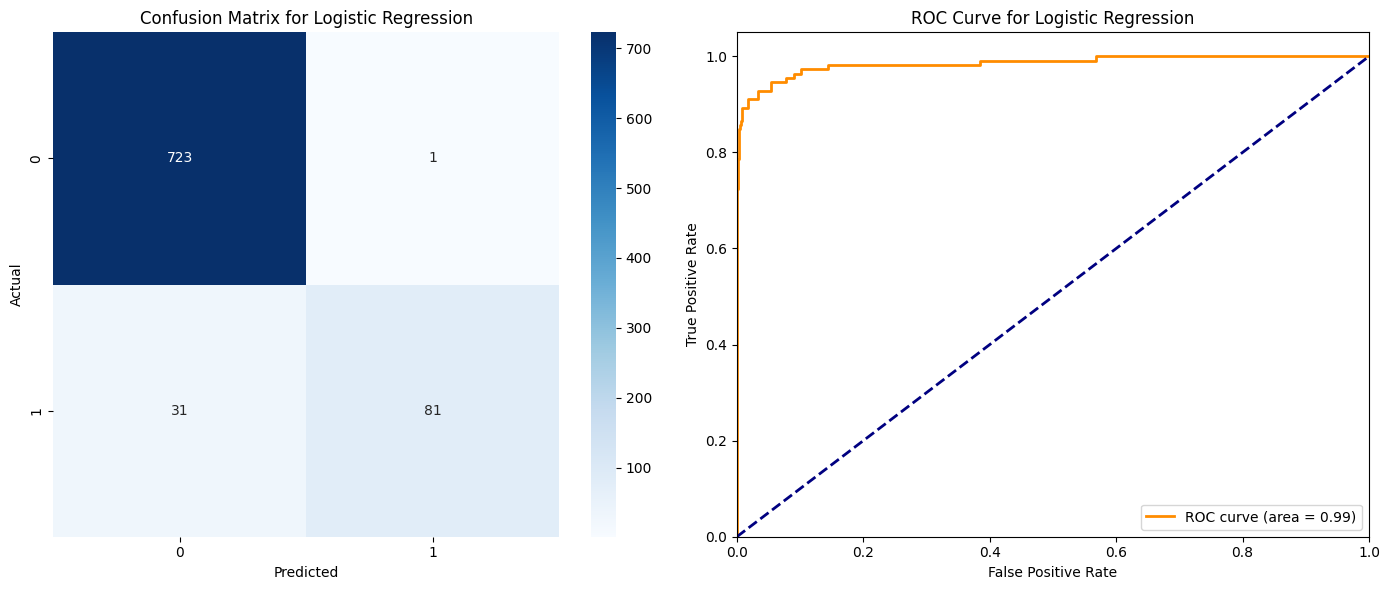

__________________________________________________
Test Metrics for Multinomial Naive Bayes:


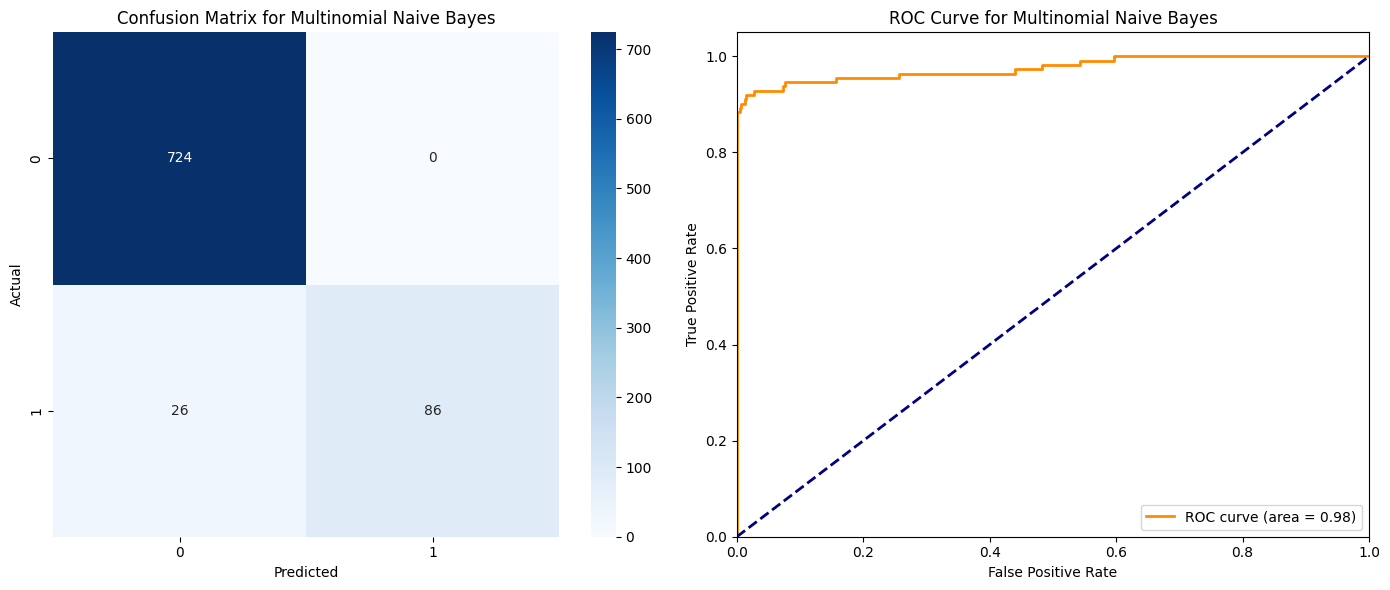

__________________________________________________
Test Metrics for Random Forest:


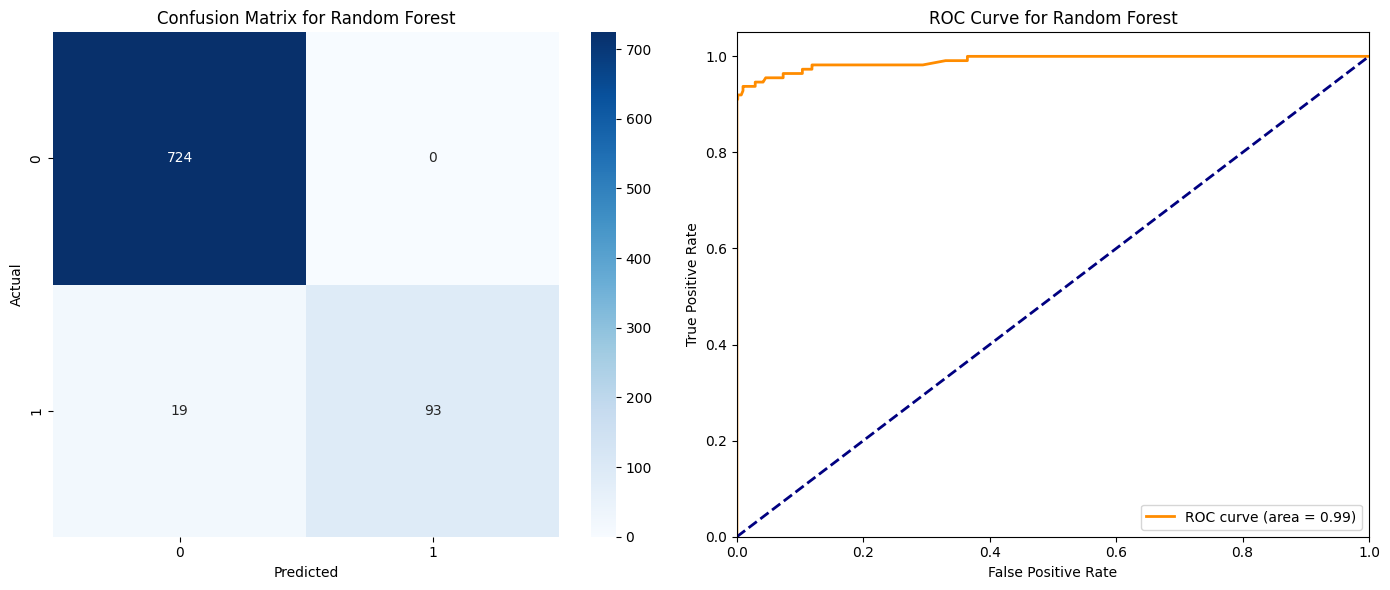

__________________________________________________
Test Metrics for XGBoost:


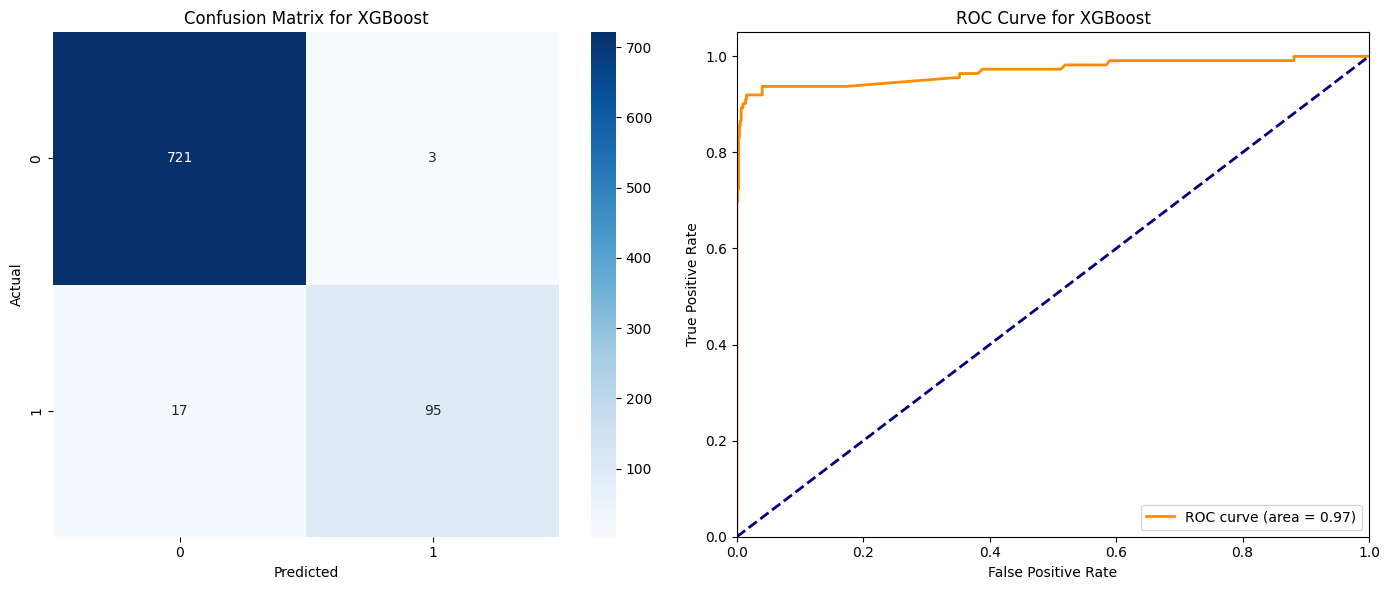

__________________________________________________


In [4]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

print("="*50)
print("Reports for Validation set")
print("="*50)

# Fit and validate models
for name, model in models.items():
    print(f"\nFitting and Validating {name}...")
    model = fit_model(model, X_train_tfidf, y_train)
    y_train_pred = model.predict(X_train_tfidf)
    y_train_pred_proba = model.predict_proba(X_train_tfidf)[:, 1]
    y_val_pred = model.predict(X_val_tfidf)
    y_val_pred_proba = model.predict_proba(X_val_tfidf)[:, 1]
    
    print(f"Validation Metrics for {name}:")
    plot_confusion_matrix_and_roc_auc(y_val, y_val_pred, y_val_pred_proba, name)
    print('_'*50)

print("="*50)
print("Reports for Test set")
print("="*50)
    
# Benchmark models on test data
print("\nBenchmarking Models on Test Data...")
for name, model in models.items():
    y_test_pred = model.predict(X_test_tfidf)
    y_test_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
    print(f"Test Metrics for {name}:")
    plot_confusion_matrix_and_roc_auc(y_test, y_test_pred, y_test_pred_proba, name)
    print('_'*50)

In [5]:
def evaluate_model_performance(model, X, y):
    """
    Evaluate a model on given data and return performance metrics
    """
    # Get predictions
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Get classification report as dict
    report = classification_report(y, y_pred, output_dict=True)
    
    # Return compiled metrics
    return {
        'precision': [report['0']['precision'], report['1']['precision']],
        'recall': [report['0']['recall'], report['1']['recall']],
        'f1': [report['0']['f1-score'], report['1']['f1-score']],
        'accuracy': report['accuracy'],
        'roc_auc': roc_auc_score(y, y_proba) if y_proba is not None else None,
        'confusion_matrix': confusion_matrix(y, y_pred)
    }

def collect_all_metrics(models, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Collect metrics for all models on train, validation, and test sets
    """
    results = {}
    
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        results[model_name] = {}
        
        # Evaluate on all datasets
        for name, X, y in [('train', X_train, y_train), 
                          ('val', X_val, y_val),
                          ('test', X_test, y_test)]:
            results[model_name][name] = evaluate_model_performance(model, X, y)
    
    return results

def create_comparison_table(results):
    """
    Create a formatted comparison table from model results
    """
    rows = []
    
    for model_name, model_results in results.items():
        for dataset, metrics in model_results.items():
            row = {
                'Model': model_name,
                'Dataset': dataset.capitalize(),
                'Precision (Class 0)': metrics['precision'][0],
                'Precision (Class 1)': metrics['precision'][1],
                'Recall (Class 0)': metrics['recall'][0],
                'Recall (Class 1)': metrics['recall'][1],
                'F1-Score (Class 0)': metrics['f1'][0],
                'F1-Score (Class 1)': metrics['f1'][1],
                'Accuracy': metrics['accuracy'],
                'ROC-AUC': metrics['roc_auc']
            }
            rows.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    # Round numeric columns to 3 decimal places
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].round(3)
    
    return df

def print_test_summary(results):
    """
    Print a summary of test set performance for all models
    """
    summary_rows = []
    
    for model_name, model_results in results.items():
        test_metrics = model_results['test']
        summary_rows.append({
            'Model': model_name,
            'Accuracy': test_metrics['accuracy'],
            'ROC-AUC': test_metrics['roc_auc'],
            'F1 (Class 1)': test_metrics['f1'][1],
            'Precision (Class 1)': test_metrics['precision'][1],
            'Recall (Class 1)': test_metrics['recall'][1]
        })
    
    summary_df = pd.DataFrame(summary_rows)
    summary_df = summary_df.round(3).sort_values('ROC-AUC', ascending=False)

def evaluate_and_compare_models(models, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Main function to evaluate and compare all models
    """
    # Fit models if not already fitted
    for name, model in models.items():
        if not hasattr(model, "classes_"):
            print(f"\nFitting {name}...")
            model.fit(X_train, y_train)
    
    # Collect all metrics
    results = collect_all_metrics(models, X_train, y_train, X_val, y_val, X_test, y_test)
    
    # Create full comparison table
    comparison_df = create_comparison_table(results)
    
    return results, comparison_df

# After defining your models:
results, comparison_df = evaluate_and_compare_models(
    models,
    X_train_tfidf, y_train,
    X_val_tfidf, y_val,
    X_test_tfidf, y_test
)


Evaluating Logistic Regression...

Evaluating Multinomial Naive Bayes...

Evaluating Random Forest...

Evaluating XGBoost...


In [6]:
comparison_df

,Model,Dataset,Precision (Class 0),Precision (Class 1),Recall (Class 0),Recall (Class 1),F1-Score (Class 0),F1-Score (Class 1),Accuracy,ROC-AUC
0,Logistic Regression,Train,0.960,0.995,0.999,0.732,0.979,0.844,0.964,0.998
1,Logistic Regression,Val,0.959,0.988,0.999,0.723,0.978,0.835,0.962,0.991
2,Logistic Regression,Test,0.959,0.988,0.999,0.723,0.978,0.835,0.962,0.985
3,Multinomial Naive Bayes,Train,0.975,1.000,1.000,0.832,0.987,0.908,0.977,0.995
4,Multinomial Naive Bayes,Val,0.950,1.000,1.000,0.661,0.974,0.796,0.954,0.971
5,Multinomial Naive Bayes,Test,0.965,1.000,1.000,0.768,0.982,0.869,0.969,0.976
6,Random Forest,Train,1.000,1.000,1.000,0.998,1.000,0.999,1.000,1.000
7,Random Forest,Val,0.968,1.000,1.000,0.786,0.984,0.880,0.971,0.981
8,Random Forest,Test,0.974,1.000,1.000,0.830,0.987,0.907,0.977,0.990
9,XGBoost,Train,0.988,1.000,1.000,0.922,0.994,0.959,0.989,0.996


In [7]:
def compare_model_predictions(models, X_test, y_test, test_data, filter_type='random', num_examples=10, max_sms_length=50):
    """
    Compares predictions made by different models against actual labels from the test set.
    
    Args:
        models (dict): Dictionary of models to compare (e.g., {"Logistic Regression": model1, ...}).
        X_test (ndarray): The test input data.
        y_test (ndarray): The actual labels for the test data (0 = Ham, 1 = Spam).
        test_data (DataFrame): Original test dataset containing messages.
        filter_type (str): Type of messages to compare ('spam', 'ham', or 'random').
        num_examples (int): The number of examples to compare.
        max_sms_length (int): Maximum length of SMS to display.
    
    Returns:
        None
    """
    # Validate filter_type
    valid_filters = ['spam', 'ham', 'random']
    if filter_type not in valid_filters:
        raise ValueError(f"filter_type must be one of {valid_filters}")
    
    # Create a list of eligible indices based on filter_type
    if filter_type == 'random':
        eligible_indices = range(len(X_test))
    else:
        target_label = 1 if filter_type == 'spam' else 0
        eligible_indices = [i for i, label in enumerate(y_test) if label == target_label]
    
    # Check if we have enough examples of the requested type
    if len(eligible_indices) < num_examples:
        print(f"Warning: Only {len(eligible_indices)} {filter_type} messages available. Showing all of them.")
        num_examples = len(eligible_indices)
    
    # Choose random examples from eligible indices
    indices = random.sample(eligible_indices, num_examples)
    
    # Print header
    header = f"{'SMS':<60} | {'Actual Label':<12} | {'Prediction Match?':<15}"
    for model_name in models.keys():
        header += f" | {model_name:<12}"
    print(header)
    print("-" * (60 + 12 + 15 + (12 + 3) * len(models)))
    
    # Track model performance
    correct_predictions = {model_name: 0 for model_name in models.keys()}
    
    # Print each example
    for idx in indices:
        # Get the actual SMS and label
        actual_sms = test_data['message'].iloc[idx]
        actual_label = y_test.iloc[idx]
        
        # Truncate SMS if needed
        if len(actual_sms) > max_sms_length:
            actual_sms = actual_sms[:max_sms_length] + "..."
        
        # Convert label to text
        actual_label_text = "spam" if actual_label == 1 else "ham"
        
        # Start building the row
        row = f"{actual_sms:<60} | {actual_label_text:<12} |"
        
        # Get and compare predictions from each model
        all_correct = True  # Track if all models predicted correctly
        
        # First, collect all predictions
        predictions = {}
        for model_name, model in models.items():
            prediction = model.predict([X_test[idx]])[0]
            prediction_text = "spam" if prediction == 1 else "ham"
            predictions[model_name] = (prediction, prediction_text)
            if prediction == actual_label:
                correct_predictions[model_name] += 1
        
        # Add match indicator
        all_match = all(pred[0] == actual_label for pred in predictions.values())
        match_indicator = "✓ All Match" if all_match else "✗ Mismatch"
        row += f" {match_indicator:<15}"
        
        # Add individual model predictions
        for model_name, (_, prediction_text) in predictions.items():
            row += f" | {prediction_text:<12}"
        
        print(row)
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Message Type: {filter_type.upper()}")
    print(f"Number of examples: {num_examples}")
    print("\nModel Accuracy on Shown Examples:")
    for model_name, correct in correct_predictions.items():
        accuracy = (correct / num_examples) * 100
        print(f"{model_name}: {accuracy:.1f}% ({correct}/{num_examples} correct)")
    print('\n\n')



# For spam messages only:
compare_model_predictions(models, X_test_tfidf, y_test, test_data, filter_type='spam', num_examples=10)

# For ham messages only:
compare_model_predictions(models, X_test_tfidf, y_test, test_data, filter_type='ham', num_examples=10)

# For random messages:
compare_model_predictions(models, X_test_tfidf, y_test, test_data, filter_type='random', num_examples=10)

SMS                                                          | Actual Label | Prediction Match? | Logistic Regression | Multinomial Naive Bayes | Random Forest | XGBoost     
---------------------------------------------------------------------------------------------------------------------------------------------------
u get phone wan na chat set meet call u cum moro l...        | spam         | ✗ Mismatch      | ham          | ham          | ham          | ham         
id like tell deepest darkest fantasy call pmin sto...        | spam         | ✓ All Match     | spam         | spam         | spam         | spam        
hi customer loyalty offerthe new nokia mobile txta...        | spam         | ✓ All Match     | spam         | spam         | spam         | spam        
free text message valid december                             | spam         | ✓ All Match     | spam         | spam         | spam         | spam        
u secret admirer looking make contact ufind rrevea...        

# Model Performance Overview

## 1. Overall Performance Summary

We evaluated four models—Logistic Regression, Multinomial Naive Bayes, Random Forest, and XGBoost—on a spam classification task using precision, recall, F1-score, accuracy, and ROC-AUC across training, validation, and test datasets.

- **Logistic Regression** performed consistently across datasets with high accuracy (~96%) but struggled with recall for Class 1 (spam).
- **Multinomial Naive Bayes** showed strong performance on training data but a significant drop in recall on validation and test sets.
- **Random Forest** achieved near-perfect performance on training data (indicating potential overfitting) but generalized well with competitive scores on validation and test sets.
- **XGBoost** demonstrated the best balance between precision and recall while maintaining strong overall metrics.

## 2. Key Observations

### 2.1 Training vs. Test Performance
- **Random Forest showed signs of overfitting**, achieving 100% precision and recall on the training set but dropping performance slightly on unseen data.
- **Logistic Regression and XGBoost maintained similar performance across datasets**, indicating good generalization.
- **Multinomial Naive Bayes had a sharp decline in recall for spam messages**, meaning it struggled to correctly identify spam in test scenarios.

### 2.2 Spam Detection Accuracy
- **Most models performed well on ham messages** (non-spam), achieving nearly 100% accuracy.
- **Spam detection was more challenging**, with some models misclassifying spam as ham (false negatives).
- **XGBoost and Random Forest had the best performance in distinguishing spam from ham**.

## 3. Model Agreement and Errors

### 3.1 Areas of Agreement
- All models correctly classified most ham messages.
- Spam messages with explicit marketing content were correctly labeled across all models.

### 3.2 Mismatches & Errors
- Some spam messages were misclassified as ham, particularly by Logistic Regression and Naive Bayes.
- Edge cases, like messages with ambiguous wording, led to inconsistent predictions across models.

## 4. Conclusion

- **XGBoost and Random Forest are the most reliable models** for this task, with XGBoost offering the best trade-off between accuracy and generalization.
- **Logistic Regression is a strong baseline but has limitations in handling complex spam patterns**.
- **Multinomial Naive Bayes, while fast and lightweight, struggles with recall in spam classification**.
- **Random Forest is highly accurate but prone to overfitting**, making it less ideal without proper regularization.

For practical deployment, **XGBoost would be the preferred choice** due to its balance between accuracy, recall, and robustness across datasets.
